# Experimenting with 3D Nifti files

In [13]:
from convert_nifti import Nifti2Numpy, Numpy2Nifti
import nibabel as nib
import numpy as np
import os
from random import random
import matplotlib.pyplot as plt


In [ ]:
brats_flair = os.path.abspath("/Users/caeochoa/Documents/GUH20/VChecklist/nn-UNet/nnUNet_raw_data_base/nnUNet_raw_data/BRATS_2021/BraTS2021_00495/BraTS2021_00495_flair.nii.gz")
brats_flair_data, brats_flair_affine, brairs_flair_header = Nifti2Numpy(brats_flair)

In [95]:
brats_flair_nifti = nib.load(brats_flair)

In [97]:
print(brats_flair_nifti.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 239.0
qoffset_z       : 0.0
srow_x          : [-1. -0. -0.  0.]
srow_y          : 

In [17]:
brats_flair_data.shape

(240, 240, 155)

My theory right now is that these coordinates are [x,y,z], in the [Axial Plane](https://www.ipfradiologyrounds.com/hrct-primer/image-reconstruction/).

I'm going to read the [nibabel docs](https://nipy.org/nibabel/coordinate_systems.html) to check if that's correct.

## Coordinate systems and Affines

Text(0.5, 0.98, 'Center slices for brats_flair image')

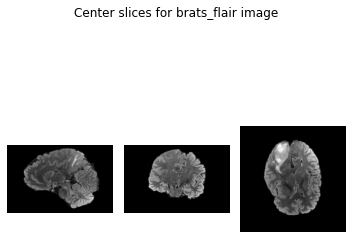

In [8]:

def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices), figsize=(5,5))
   if len(slices) == 1:
       axes.imshow(slices[0].T, cmap="gray", origin="lower")
   else:
       for i, slice in enumerate(slices):
           axes[i].imshow(slice.T, cmap="gray", origin="lower")
           axes[i].axis("off")
   fig.subplots_adjust(wspace=0, hspace=0)
   fig.tight_layout()


slice_0 = brats_flair_data[120, :, :] # sagittal plane
slice_1 = brats_flair_data[:, 120, :] # coronal plane
slice_2 = brats_flair_data[:, :, 77] # axial plane -- my theory was correct!!!

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for brats_flair image")  

Text(0.5, 0.98, 'Center slices for brats_seg image')

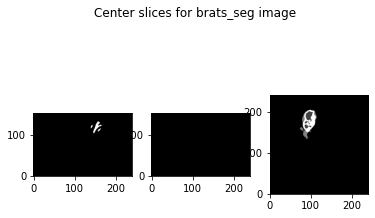

In [19]:
brats_seg = os.path.abspath("/Users/caeochoa/Documents/GUH20/VChecklist/nn-UNet/nnUNet_raw_data_base/nnUNet_raw_data/BRATS_2021/BraTS2021_00495/BraTS2021_00495_seg.nii.gz")
brats_seg_data, brats_seg_affine = Nifti2Numpy(brats_seg)

slice_0 = brats_seg_data[120, :, :] # sagittal plane
slice_1 = brats_seg_data[:, 120, :] # coronal plane
slice_2 = brats_seg_data[:, :, 77] # axial plane -- my theory was correct!!!

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for brats_seg image") 

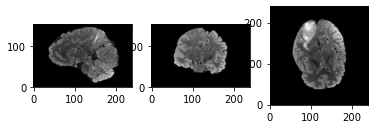

In [20]:
brats_overlay = brats_seg_data + brats_flair_data

show_slices([brats_overlay[120,:,:], brats_overlay[:,120,:], brats_overlay[:,:,77]])

In [29]:
tumor = brats_seg_data[brats_seg_data > 0]
print(tumor)

[2 2 2 ... 2 2 2]


# Test type modifications

I'm going to fix the patch size to 20x20x31 to start (155 can be divided only by 31 and 5).

In [5]:
PATCH_SIZE = (20,20,31)
PATCH_PER_SIDE = np.array(brats_flair_data.shape)//np.array(PATCH_SIZE)

## Crop into patches

In [39]:
patches = np.zeros(np.append(PATCH_PER_SIDE, PATCH_SIZE))
patches.shape

(12, 12, 5, 20, 20, 31)

In [40]:
for i in range(PATCH_PER_SIDE[0]):
    for j in range(PATCH_PER_SIDE[1]):
        for k in range(PATCH_PER_SIDE[2]):
            patches[i,j,k] = brats_flair_data[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1], k:k+PATCH_SIZE[2]]
    

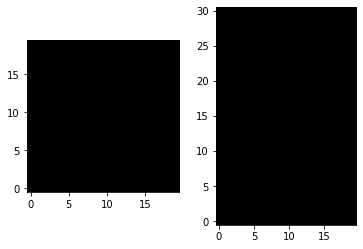

In [58]:
show_slices([patches[6,6,2,:,:,15],patches[6,6,2,:,10,:]])
#patches[6,6,2,:,:,15].shape

In [48]:
def show_patches(patches, PATCH_PER_SIDE, span=0, label=False):

    fig, ax = plt.subplots(PATCH_PER_SIDE, PATCH_PER_SIDE, figsize=(5, 5))

    for idy in range(PATCH_PER_SIDE):
        for idx in range(PATCH_PER_SIDE):
            ax[idy, idx].imshow(patches[idy, idx], cmap="gray", origin="lower")
            ax[idy, idx].axis('off')
            if label:
                ax[idy, idx].text(0,25, f"{idy}, {idx}", color='red', weight='bold')


    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()


    plt.subplots_adjust(wspace=span, hspace=span)



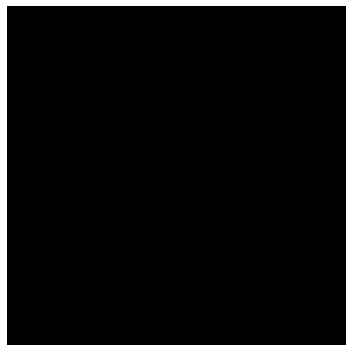

In [49]:
show_patches(patches[:,:,2,:,:,15], PATCH_PER_SIDE[0])

## Random Rotation

In [77]:
# without dividing into patches, perform random patch rotation
ROT_PROP = 0.5

perturbed = brats_flair_data.copy()

for i,x in enumerate(range(0, brats_flair_data.shape[0], PATCH_SIZE[0])):
    for j,y in enumerate(range(0,brats_flair_data.shape[1], PATCH_SIZE[1])):
        for k,z in enumerate(range(0,brats_flair_data.shape[2], PATCH_SIZE[2])):
            if random() <= ROT_PROP:
                perturbed[x:x+PATCH_SIZE[0], y:y+PATCH_SIZE[1], z:z+PATCH_SIZE[2]] = np.rot90(perturbed[x:x+PATCH_SIZE[0], y:y+PATCH_SIZE[1], z:z+PATCH_SIZE[2]])



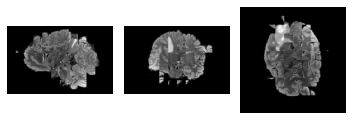

In [80]:
# visualise with centre slices

show_slices([perturbed[perturbed.shape[0]//2,:,:], perturbed[:,perturbed.shape[1]//2,:], perturbed[:,:,perturbed.shape[2]//2]])

## Central Rotation

In [81]:
# without dividing into patches, perform random patch rotation
ROT_PROP = 0.5

perturbed = brats_flair_data.copy()

for i,x in enumerate(range(0, brats_flair_data.shape[0], PATCH_SIZE[0])):
    for j,y in enumerate(range(0,brats_flair_data.shape[1], PATCH_SIZE[1])):
        for k,z in enumerate(range(0,brats_flair_data.shape[2], PATCH_SIZE[2])):
            if (PATCH_PER_SIDE[0]-1)/4 <= i < (PATCH_PER_SIDE[0]-1)*3/4 and (PATCH_PER_SIDE[1]-1)/4 <= j < (PATCH_PER_SIDE[1]-1)*3/4 and (PATCH_PER_SIDE[2]-1)/4 <= k < (PATCH_PER_SIDE[2]-1)*3/4:
                if random() <= ROT_PROP:
                    perturbed[x:x+PATCH_SIZE[0], y:y+PATCH_SIZE[1], z:z+PATCH_SIZE[2]] = np.rot90(perturbed[x:x+PATCH_SIZE[0], y:y+PATCH_SIZE[1], z:z+PATCH_SIZE[2]])



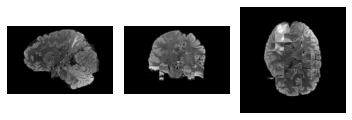

In [82]:
# visualise with centre slices

show_slices([perturbed[perturbed.shape[0]//2,:,:], perturbed[:,perturbed.shape[1]//2,:], perturbed[:,:,perturbed.shape[2]//2]])

## Outer Rotation

In [6]:
# without dividing into patches, perform random patch rotation
ROT_PROP = 0.5

perturbed = brats_flair_data.copy()

for i,x in enumerate(range(0, brats_flair_data.shape[0], PATCH_SIZE[0])):
    for j,y in enumerate(range(0,brats_flair_data.shape[1], PATCH_SIZE[1])):
        for k,z in enumerate(range(0,brats_flair_data.shape[2], PATCH_SIZE[2])):
            if not ((PATCH_PER_SIDE[0]-1)/4 <= i < (PATCH_PER_SIDE[0]-1)*3/4 and (PATCH_PER_SIDE[1]-1)/4 <= j < (PATCH_PER_SIDE[1]-1)*3/4 and (PATCH_PER_SIDE[2]-1)/4 <= k < (PATCH_PER_SIDE[2]-1)*3/4):
                if random() <= ROT_PROP:
                    perturbed[x:x+PATCH_SIZE[0], y:y+PATCH_SIZE[1], z:z+PATCH_SIZE[2]] = np.rot90(perturbed[x:x+PATCH_SIZE[0], y:y+PATCH_SIZE[1], z:z+PATCH_SIZE[2]])



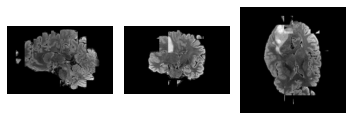

In [84]:
# visualise with centre slices

show_slices([perturbed[perturbed.shape[0]//2,:,:], perturbed[:,perturbed.shape[1]//2,:], perturbed[:,:,perturbed.shape[2]//2]])

In [86]:
type(perturbed)

numpy.ndarray

In [7]:
hi = perturbed.copy()
hi = np.expand_dims(hi, 0)
print(hi.shape)
hi = np.append(hi, np.expand_dims(perturbed, 0), 0)
print(hi.shape)
for i in hi[1:]:
    print(i.shape)

(1, 240, 240, 155)
(2, 240, 240, 155)
(240, 240, 155)


In [12]:
path = "None"
if path:
    print("hi")

hi


In [14]:
nib.save(Numpy2Nifti(perturbed, brats_flair_affine, brairs_flair_header), "test/perturbed")

FileNotFoundError: [Errno 2] No such file or directory: 'test/perturbed.nii'

In [7]:
# truth test
statement = 0 == 0
print(statement)

True


In [8]:
print(statement*-1)

-1


# Displaying slices

In [3]:
import matplotlib.pyplot as plt
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices), figsize=(5,5))
   if len(slices) == 1:
       axes.imshow(slices[0].T, cmap="gray", origin="lower")
   else:
       for i, slice in enumerate(slices):
           axes[i].imshow(slice.T, cmap="gray", origin="lower")
           axes[i].axis("off")
   fig.subplots_adjust(wspace=0, hspace=0)
   fig.tight_layout()

In [4]:
flair = os.path.abspath("/Users/Cesar/Documents/GUH20/VChecklist/survey_prep/images/BraTS2021_00000_0000.nii.gz")
flair_data, flair_affine, flair_header = Nifti2Numpy(flair)

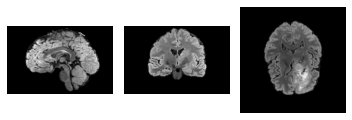

In [7]:
slice_0 = flair_data[120, :, :] # sagittal plane
slice_1 = flair_data[:, 120, :] # coronal plane
slice_2 = flair_data[:, :, 77] # axial plane -- my theory was correct!!!

show_slices([slice_0, slice_1, slice_2])
#plt.suptitle("Center slices for brats_flair image")  

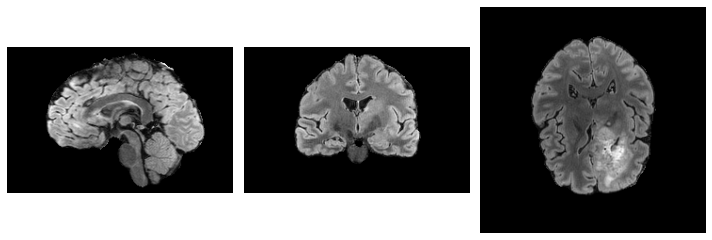

In [12]:
slices = [slice_0, slice_1, slice_2]

fig, axes = plt.subplots(1, len(slices), figsize=(10,10))
if len(slices) == 1:
    axes.imshow(slices[0].T, cmap="gray", origin="lower")
else:
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        axes[i].axis("off")
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

In [13]:
labels = Nifti2Numpy(os.path.abspath("/Users/Cesar/Documents/GUH20/VChecklist/survey_prep/labels/BraTS2021_00000.nii.gz"))[0]

In [14]:
label_0 = labels[120, :, :] # sagittal plane
label_1 = labels[:, 120, :] # coronal plane
label_2 = labels[:, :, 77] # axial plane -- my theory was correct!!!

label_slices = [label_0, label_1, label_2]


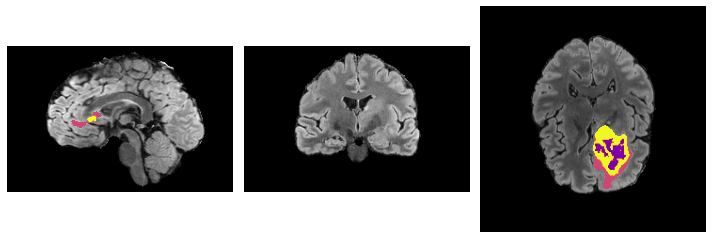

In [49]:
fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
if len(slices) == 1:
    axes.imshow(slices[0].T, cmap="gray", origin="lower")
else:
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        alpha = label_slices[i].T > 0
        alpha = alpha.astype(np.uint8)
        axes[i].imshow(label_slices[i].T, cmap="plasma", origin="lower", alpha=alpha)
        axes[i].axis("off")
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#plt.savefig("og_labeled_slices.pdf")

In [50]:
output = Nifti2Numpy(os.path.abspath("/Users/Cesar/Documents/GUH20/VChecklist/survey_prep/outputs/Task500_BraTS2021/BraTS2021_00000.nii.gz"))[0]

In [51]:
output_0 = output[120, :, :] # sagittal plane
output_1 = output[:, 120, :] # coronal plane
output_2 = output[:, :, 77] # axial plane -- my theory was correct!!!

output_slices = [output_0, output_1, output_2]


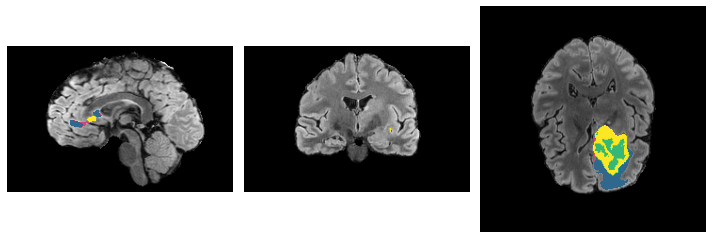

In [52]:
fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
if len(slices) == 1:
    axes.imshow(slices[0].T, cmap="gray", origin="lower")
else:
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        alpha = label_slices[i].T > 0
        alpha = alpha.astype(np.uint8)
        axes[i].imshow(label_slices[i].T, cmap="plasma", origin="lower", alpha=alpha)
        alpha = output_slices[i].T > 0
        alpha = alpha.astype(np.uint8)
        axes[i].imshow(output_slices[i].T, cmap="viridis", origin="lower", alpha=alpha)
        axes[i].axis("off")
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#plt.savefig("og_labeled_slices.pdf")

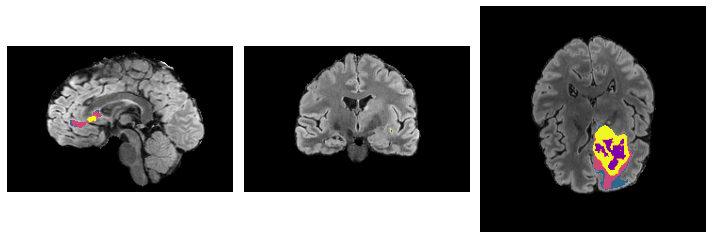

In [53]:
fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
if len(slices) == 1:
    axes.imshow(slices[0].T, cmap="gray", origin="lower")
else:
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        alpha = output_slices[i].T > 0
        alpha = alpha.astype(np.uint8)
        axes[i].imshow(output_slices[i].T, cmap="viridis", origin="lower", alpha=alpha)
        alpha = label_slices[i].T > 0
        alpha = alpha.astype(np.uint8)
        axes[i].imshow(label_slices[i].T, cmap="plasma", origin="lower", alpha=alpha)
        axes[i].axis("off")
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
#plt.savefig("og_labeled_slices.pdf")

In [60]:
def show_slices_multiple(list_of_slices):
    fig, axes = plt.subplots(1, len(list_of_slices[0]), figsize=(10,5))
    assert len(list_of_slices) <= 3, "Too many slices"
    cmap = ["gray", "plasma", "viridis"]
    for j, slices in enumerate(list_of_slices):
        for i, slice in enumerate(slices):
            if j == 0:
                axes[i].imshow(slice.T, cmap=cmap[j], origin="lower")#, alpha=alpha)
                axes[i].axis("off")
            else:
                alpha = slice.T > 0
                alpha = alpha.astype(np.uint8)
                im = axes[i].imshow(slice.T, cmap=cmap[j], origin="lower", alpha=alpha)
                values = np.unique(slice)[1:]
                colors = [ im.cmap(im.norm(value)) for value in values]
                labels = {"0": "Everything else", "1": "NCR", "2": "ED", "4": "ET", "3":"ET"}
                patches = [ mpatches.Patch(color=colors[i], label=labels[str(values[i])] ) for i in range(len(values)) ]
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
                
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()

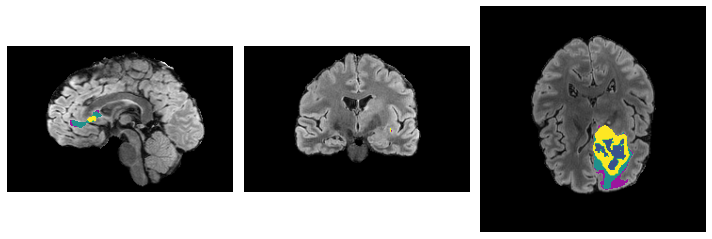

In [109]:
show_slices_multiple([slices, output_slices, label_slices])
plt.savefig("hey.png")

In [122]:
files = [flair, os.path.abspath("/Users/Cesar/Documents/GUH20/VChecklist/survey_prep/outputs/Task500_BraTS2021/BraTS2021_00000.nii.gz")]
data = [Nifti2Numpy(file) for file in files]
#data_slices = [[layer[120,:,:], layer[:,120,:], layer[:,:,77]] for layer in data]

In [124]:
print(data[0])

(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ...,

In [120]:
for i,slice in enumerate(slices):
    assert data_slices[0][i].all() == slice.all()

# Understanding labels and outputs

In [31]:
output_path = os.path.abspath("/Users/Cesar/VChecklist/nn-UNet/outputs/BraTS2021/495/BraTS2021_00495.nii.gz")
label_path = os.path.abspath("/Users/Cesar/VChecklist/nn-UNet/nnUNet_raw_data_base/nnUNet_raw_data/Task500_BraTS2021/BraTS2021_00495/labels/BraTS2021_00495.nii.gz")

output = Nifti2Numpy(output_path)[0]
label = Nifti2Numpy(label_path)[0]

In [6]:
print(output.shape, label.shape)

(240, 240, 155) (240, 240, 155)


In [8]:
print(np.unique(output), np.unique(label))

[0 1 2 3] [0 1 2 4]


In [10]:
flair_path = os.path.abspath("/Users/Cesar/VChecklist/nn-UNet/nnUNet_raw_data_base/nnUNet_raw_data/Task500_BraTS2021/BraTS2021_00495/BraTS2021_00495_flair.nii.gz")
flair = Nifti2Numpy(flair_path)[0]

In [52]:
slices = lambda x: [x[120,:,:],x[:,120,:], x[:,:,77]]
flair_slices = slices(flair)
output_slices = slices(output)
label_slices = slices(label)




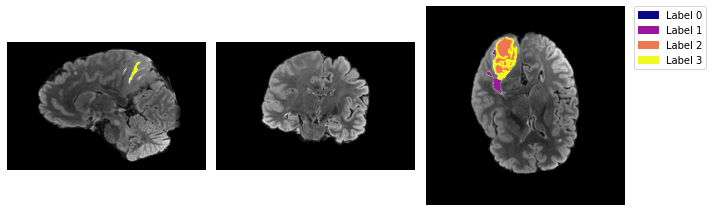

In [56]:
show_slices_multiple([flair_slices, output_slices])

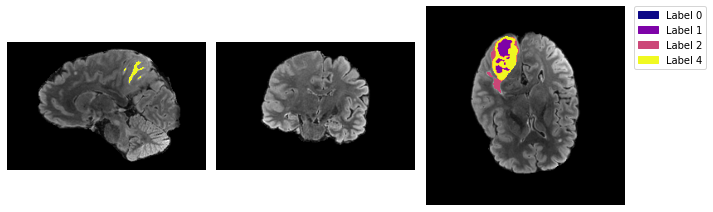

In [54]:
show_slices_multiple([flair_slices, label_slices])

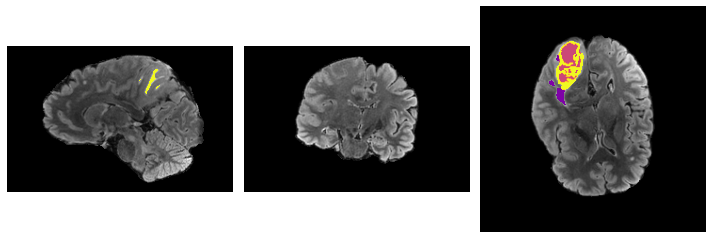

In [32]:
test1 = np.copy(output)
test1[test1 == 3] = 4
show_slices_multiple([flair_slices, slices(test1)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


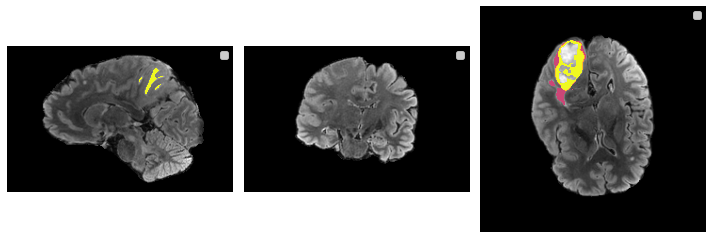

In [48]:
test2 = np.copy(label)
test2[test2 == 1] = 0
show_slices_multiple([flair_slices, slices(test2)])

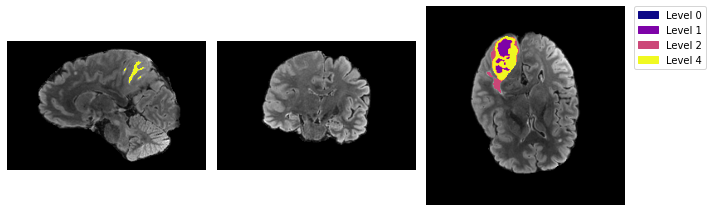

In [46]:
import matplotlib.patches as mpatches
fig, axes = plt.subplots(1, len(flair_slices), figsize=(10,5))
if len(flair_slices) == 1:
    axes.imshow(slices[0].T, cmap="gray", origin="lower")
else:
    for i, slic in enumerate(flair_slices):
        axes[i].imshow(slic.T, cmap="gray", origin="lower")
        alpha = label_slices[i].T > 0
        alpha = alpha.astype(np.uint8)
        im = axes[i].imshow(label_slices[i].T, cmap="plasma", origin="lower", alpha=alpha)
        axes[i].axis("off")
        values = np.unique(label)
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

TypeError: Invalid shape (240,) for image data

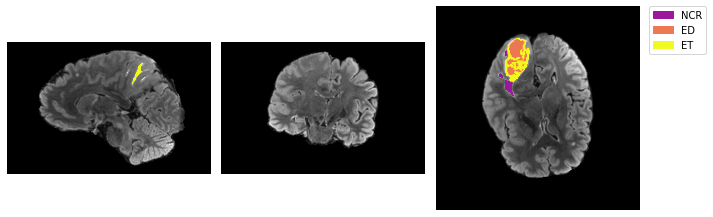

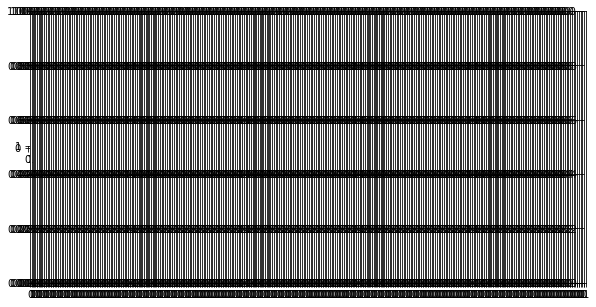

In [62]:
show_slices_multiple([flair_slices, output_slices])
show_slices_multiple([flair_slices, label_slices])

In [64]:
def show_slices_single(list_of_slices):
    fig, axes = plt.subplots(1, len(list_of_slices[0]), figsize=(10,5))
    assert len(list_of_slices) <= 3, "Too many slices"
    cmap = ["gray", "plasma", "viridis"]
    for j, slices in enumerate(list_of_slices):
        for i, slice in enumerate(slices):
            if j == 0:
                axes.imshow(slice.T, cmap=cmap[j], origin="lower")#, alpha=alpha)
                axes.axis("off")
            else:
                alpha = slice.T > 0
                alpha = alpha.astype(np.uint8)
                im = axes.imshow(slice.T, cmap=cmap[j], origin="lower", alpha=alpha)
                values = np.unique(slice)[1:]
                colors = [ im.cmap(im.norm(value)) for value in values]
                labels = {"0": "Everything else", "1": "NCR", "2": "ED", "4": "ET", "3":"ET"}
                patches = [ mpatches.Patch(color=colors[i], label=labels[str(values[i])] ) for i in range(len(values)) ]
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
                
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()

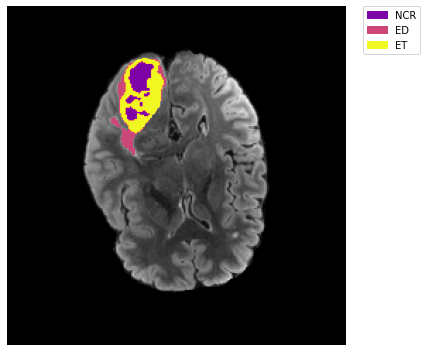

In [67]:
show_slices_single([[flair_slices[2]], [label_slices[2]]])
plt.savefig("figures/labels.png")